## Linking a dataset of real historical persons
In this example, we deduplicate a more realistic dataset. The data is based on historical persons scraped from wikidata. Duplicate records are introduced with a variety of errors introduced.

In [1]:
from splink.athena.athena_linker import AthenaLinker
import altair as alt
alt.renderers.enable('mimetype')

import pandas as pd
pd.options.display.max_rows = 1000
df = pd.read_parquet("./data/historical_figures_with_errors_50k.parquet")

Create a boto3 session to be used within the linker

In [2]:
import boto3
my_session = boto3.Session(region_name="eu-west-1")

In [3]:
# Simple settings dictionary will be used for exploratory analysis
settings = {
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name and l.surname = r.surname",
        "l.surname = r.surname and l.dob = r.dob",
        "l.first_name = r.first_name and l.dob = r.dob",
        "l.postcode_fake = r.postcode_fake and l.first_name = r.first_name",
    ],
}

## AthenaLinker Setup

To work nicely with Athena, you need to outline various filepaths, buckets and the database(s) you wish to interact with.
<hr>

**The AthenaLinker has three required inputs:**
* input_table_or_tables - the input table to use for linking. This can either be a table in a database or a pandas dataframe
* output_database - the database to output all of your splink tables to.
* output_bucket - the s3 bucket you wish any parquet files produced by splink to be output to.

**and two optional inputs:**
* output_filepath - the s3 filepath to output files to. This is an extension of output_bucket and dictate the full filepath your files will be output to.
* input_table_aliases - the name of your table within your database, should you choose to use a pandas df as an input.

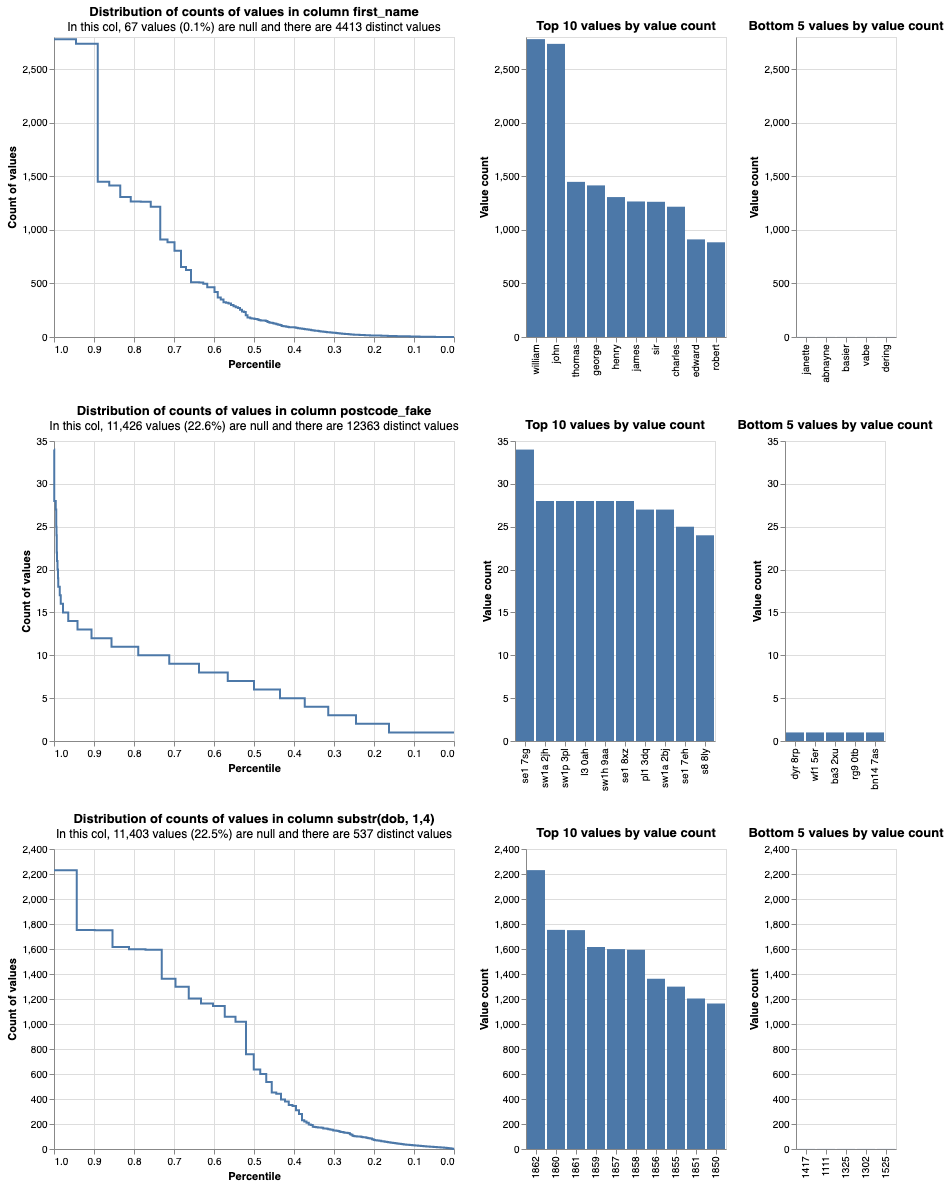

In [4]:
# Set the output bucket and the additional filepath to write outputs to
############################################
# EDIT THESE BEFORE ATTEMPTING TO RUN THIS #
############################################

bucket = "my_s3_bucket"
database = "my_athena_database"
filepath = "athena_testing"  # file path inside of your bucket
aws_filepath = f"s3://{bucket}/{filepath}"

# Sessions are generated with a unique ID...
linker = AthenaLinker(
    input_table_or_tables=df,
    boto3_session=my_session,
    # the bucket to store splink's parquet files
    output_bucket=bucket,
    # the database to store splink's outputs
    output_database=database,
    # folder to output data to
    output_filepath=filepath,  
    # table name within your database
    # if blank, it will default to __splink__input_table_randomid
    input_table_aliases="__splink__testings",
    settings_dict=settings,
)

linker.profile_columns(
    ["first_name", "postcode_fake", "substr(dob, 1,4)"], top_n=10, bottom_n=5
)

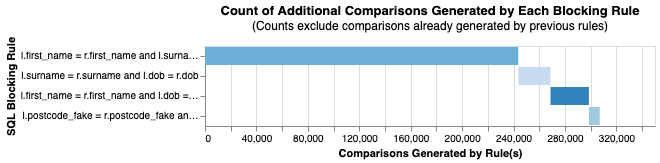

In [5]:
linker.cumulative_num_comparisons_from_blocking_rules_chart()

### Perform garbage collection

To clean up your selected database and its backing data on AWS, you can use `drop_all_tables_created_by_splink`. This allows splink to automatically search for any tables prefixed with `__splink__df...` in your given database and delete them.

Alternatively, if you want to delete splink tables from another database that you didn't select in the initialisation step, you can run `drop_splink_tables_from_database(database_name)`.

In [6]:
linker.drop_all_tables_created_by_splink(delete_s3_folders=True)

In [7]:
import splink.athena.athena_comparison_library as cl

settings = {
    "link_type": "dedupe_only",
    "blocking_rules_to_generate_predictions": [
        "l.first_name = r.first_name and l.surname = r.surname",
        "l.surname = r.surname and l.dob = r.dob",
        "l.first_name = r.first_name and l.dob = r.dob",
        "l.postcode_fake = r.postcode_fake and l.first_name = r.first_name",
    ],
    "comparisons": [
        cl.levenshtein_at_thresholds("first_name", [1,2], term_frequency_adjustments=True),
        cl.levenshtein_at_thresholds("surname", [1,2], term_frequency_adjustments=True),
        cl.levenshtein_at_thresholds("dob", [1,2], term_frequency_adjustments=True),
        cl.levenshtein_at_thresholds("postcode_fake", 2,term_frequency_adjustments=True),
        cl.exact_match("birth_place", term_frequency_adjustments=True),
        cl.exact_match("occupation",  term_frequency_adjustments=True),
    ],
    "retain_matching_columns": True,
    "retain_intermediate_calculation_columns": True,
    "max_iterations": 10,
    "em_convergence": 0.01
}

### You can also read data directly from a database

Simply add your data to your database and enter the name of the resulting table into the linker object.

This can be done with either:
> wr.catalog.create_parquet_table(...)

or

> wr.s3.to_parquet(...)

See the [awswrangler API](https://aws-sdk-pandas.readthedocs.io/en/stable/api.html) for more info.

In [ ]:
# Write our dataframe to s3/our backing database
import awswrangler as wr
wr.s3.to_parquet(
    df,  # pandas dataframe
    path=f"{aws_filepath}/historical_figures_with_errors_50k",
    dataset=True,
    database=database,
    table="historical_figures_with_errors_50k",
    mode="overwrite",
    compression="snappy",
)

In [9]:
# Initialise our linker with historical_figures_with_errors_50k from our database
linker = AthenaLinker(
    input_table_or_tables="historical_figures_with_errors_50k",  
    settings_dict=settings,
    boto3_session=my_session,
    output_bucket=bucket,  # the bucket to store splink's parquet files 
    output_database=database,  # the database to store splink's outputs
    output_filepath=filepath  # folder to output data to
)

In [10]:
linker.training.estimate_probability_two_random_records_match(
    [
        "l.first_name = r.first_name and l.surname = r.surname and l.dob = r.dob",
        "substr(l.first_name,1,2) = substr(r.first_name,1,2) and l.surname = r.surname and substr(l.postcode_fake,1,2) = substr(r.postcode_fake,1,2)",
        "l.dob = r.dob and l.postcode_fake = r.postcode_fake",
    ],
    recall=0.6,
)

Probability two random records match is estimated to be  0.000136.
This means that amongst all possible pairwise record comparisons, one in 7,362.31 are expected to match.  With 1,279,041,753 total possible comparisons, we expect a total of around 173,728.33 matching pairs


In [11]:
linker.training.estimate_u_using_random_sampling(max_pairs=5e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trained).
    - dob (no m values are trained).
    - postcode_fake (no m values are trained).
    - birth_place (no m values are trained).
    - occupation (no m values are trained).


In [12]:
blocking_rule = "l.first_name = r.first_name and l.surname = r.surname"
training_session_names = linker.training.estimate_parameters_using_expectation_maximisation(blocking_rule)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.first_name = r.first_name and l.surname = r.surname

Parameter estimates will be made for the following comparison(s):
    - dob
    - postcode_fake
    - birth_place
    - occupation

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - first_name
    - surname

Iteration 1: Largest change in params was -0.533 in probability_two_random_records_match
Iteration 2: Largest change in params was -0.0419 in the m_probability of birth_place, level `All other comparisons`
Iteration 3: Largest change in params was -0.0154 in the m_probability of birth_place, level `All other comparisons`
Iteration 4: Largest change in params was 0.00489 in the m_probability of birth_place, level `Exact match`

EM converged after 4 iterations

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).

In [13]:
blocking_rule = "l.dob = r.dob"
training_session_dob = linker.training.estimate_parameters_using_expectation_maximisation(blocking_rule)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.dob = r.dob

Parameter estimates will be made for the following comparison(s):
    - first_name
    - surname
    - postcode_fake
    - birth_place
    - occupation

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - dob

Iteration 1: Largest change in params was -0.356 in the m_probability of first_name, level `Exact match`
Iteration 2: Largest change in params was 0.0401 in the m_probability of first_name, level `All other comparisons`
Iteration 3: Largest change in params was 0.00536 in the m_probability of first_name, level `All other comparisons`

EM converged after 3 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


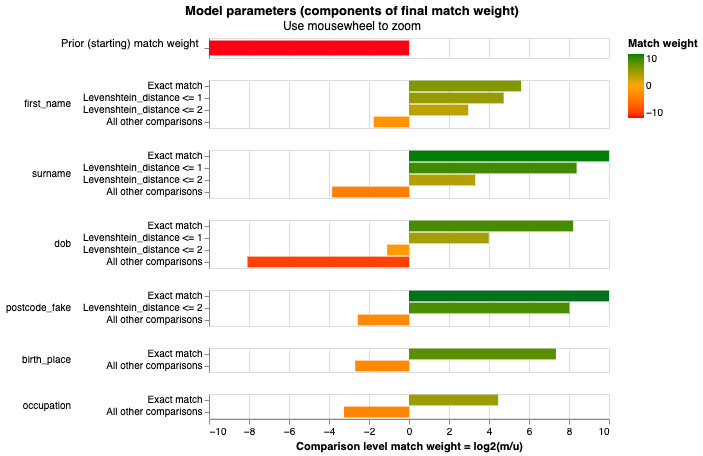

In [14]:
linker.visualisations.match_weights_chart()

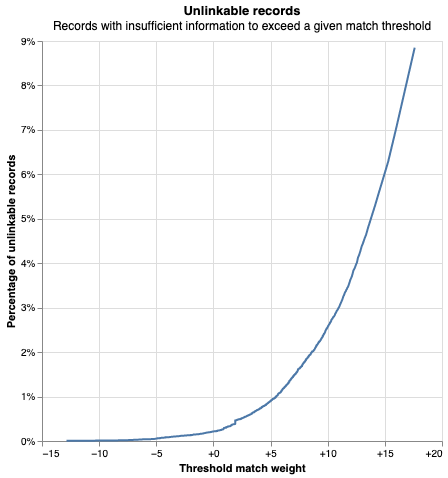

In [15]:
linker.evaluation.unlinkables_chart()

In [16]:
df_predict = linker.inference.predict()
df_e = df_predict.as_pandas_dataframe(limit=5)
df_e

match_weight  match_probability unique_id_l unique_id_r first_name_l  \
0     19.465751           0.999999  Q5536981-1  Q5536981-4       george   
1     33.572592           1.000000  Q5536981-1  Q5536981-5       george   
2     33.572592           1.000000  Q5536981-1  Q5536981-6       george   
3     33.572592           1.000000  Q5536981-1  Q5536981-7       george   
4     22.025628           1.000000  Q5536981-1  Q5536981-8       george   

  first_name_r  gamma_first_name  tf_first_name_l  tf_first_name_r  \
0       george                 3         0.028014         0.028014   
1       george                 3         0.028014         0.028014   
2       george                 3         0.028014         0.028014   
3       george                 3         0.028014         0.028014   
4       george                 3         0.028014         0.028014   

   bf_first_name  ...  bf_birth_place bf_tf_adj_birth_place occupation_l  \
0      48.723867  ...       162.73433              0.097709   politician   
1      48.723867  ...       162.73433              0.097709   politician   
2      48.723867  ...       162.73433              0.097709   politician   
3      48.723867  ...       162.73433              0.097709   politician   
4      48.723867  ...       162.73433              0.097709   politician   

   occupation_r  gamma_occupation  tf_occupation_l  tf_occupation_r  \
0    politician                 1         0.088932         0.088932   
1    politician                 1         0.088932         0.088932   
2    politician                 1         0.088932         0.088932   
3    politician                 1         0.088932         0.088932   
4    politician                 1         0.088932         0.088932   

   bf_occupation bf_tf_adj_occupation match_key  
0      21.983413             0.459975         0  
1      21.983413             0.459975         0  
2      21.983413             0.459975         0  
3      21.983413             0.459975         0  
4      21.983413             0.459975         0  

[5 rows x 47 columns]

You can also view rows in this dataset as a waterfall chart as follows:

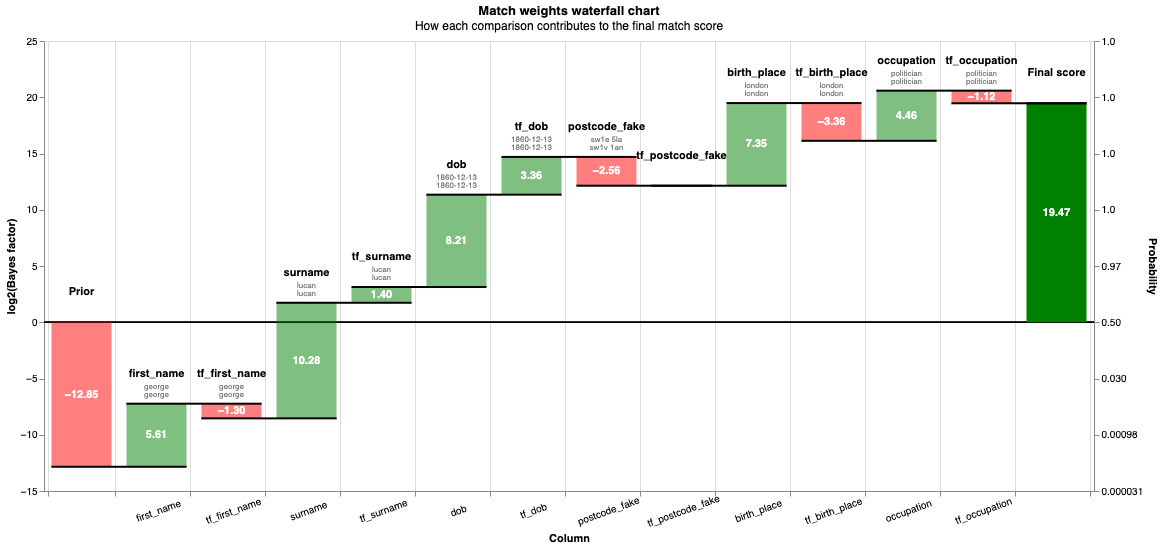

In [17]:
from splink.charts import waterfall_chart
records_to_plot = df_e.to_dict(orient="records")
linker.visualisations.waterfall_chart(records_to_plot, filter_nulls=False)

In [18]:
clusters = linker.clustering.cluster_pairwise_predictions_at_threshold(df_predict, threshold_match_probability=0.95)

Completed iteration 1, root rows count 642
Completed iteration 2, root rows count 119
Completed iteration 3, root rows count 35
Completed iteration 4, root rows count 6
Completed iteration 5, root rows count 0


In [ ]:
linker.visualisations.cluster_studio_dashboard(df_predict, clusters, "dashboards/50k_cluster.html", sampling_method='by_cluster_size', overwrite=True)

from IPython.display import IFrame

IFrame(
    src="./dashboards/50k_cluster.html", width="100%", height=1200
)

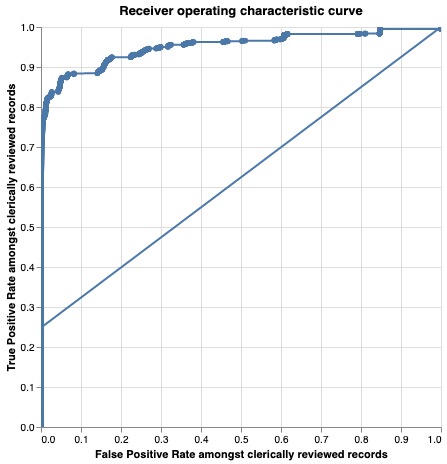

In [20]:
linker.roc_chart_from_labels_column("cluster",match_weight_round_to_nearest=0.02)

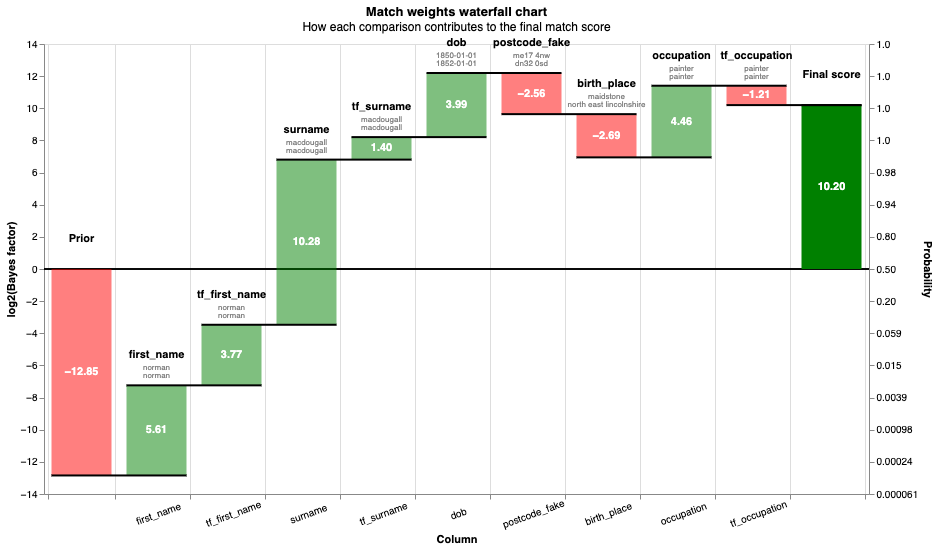

In [21]:
records = linker.evaluation.prediction_errors_from_labels_column(
    "cluster",
    threshold=0.999,
    include_false_negatives=False,
    include_false_positives=True,
).as_record_dict()
linker.visualisations.waterfall_chart(records)

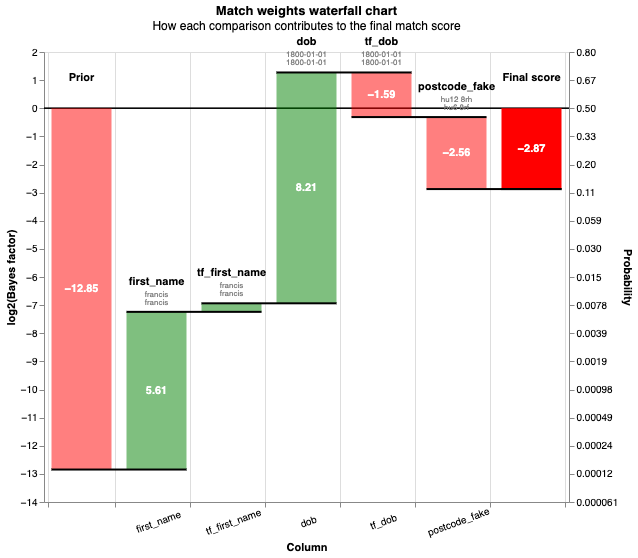

In [22]:
# Some of the false negatives will be because they weren't detected by the blocking rules
records = linker.evaluation.prediction_errors_from_labels_column(
    "cluster",
    threshold=0.5,
    include_false_negatives=True,
    include_false_positives=False,
).as_record_dict(limit=50)

linker.visualisations.waterfall_chart(records)

**And finally, clean up all tables except `df_predict`**

In [23]:
linker.drop_tables_in_current_splink_run(tables_to_exclude=df_predict)